# Google Summer of Code 2022 

#### Luis Roberto Cervantes Guevara

# Task 1


In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq
    print("installed cirq.")
import numpy as np
import matplotlib.pyplot as plt

In [2]:
qubits = [cirq.GridQubit(x, y) for x in range(5) for y in range(1)]

print(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(3, 0), cirq.GridQubit(4, 0)]


In [3]:
from cirq.ops import H,CNOT,SWAP,rx
theta=np.pi/2
q = [cirq.GridQubit(i,0) for i in range(5)]
circuit=cirq.Circuit(
    cirq.H.on_each(*q))
for j in range(4):
    circuit.append([CNOT(q[j],q[j+1])])
circuit.append([SWAP(q[0],q[4])])
circuit.append([rx(theta).on(q[2])])
print(circuit)

(0, 0): ───H───@──────────────────────×───
               │                      │
(1, 0): ───H───X───@──────────────────┼───
                   │                  │
(2, 0): ───H───────X───@───Rx(0.5π)───┼───
                       │              │
(3, 0): ───H───────────X───@──────────┼───
                           │          │
(4, 0): ───H───────────────X──────────×───


In [4]:
q2=cirq.LineQubit(1)
#q3=cirq.LineQubit(2)
circuit2=cirq.Circuit()
theta1=np.pi/8
for i in range(5):
    circuit2.append(cirq.rx(theta1).on(q2))
    theta1=theta1+np.pi/16
#circuit2.append(cirq.H(q3))
circuit2.append(cirq.measure(q2))
#circuit2.append(cirq.measure(q3))
print(circuit2)

1: ───Rx(0.125π)───Rx(0.188π)───Rx(0.25π)───Rx(0.312π)───Rx(0.375π)───M───


1=11111111111111111111111111111111110111101111111011111111111111111111011110111110111010101111111110100111111111111111111111111110111111110101111101111111011111111111111111111100111111111111111011111110111111110111101111011100110111111011111111111111010010010111111110111111011111111111111111111111111111101010100101111111111111101101011111111111111111011111011111111111111111110001111111111101111011111111101111111110111111111111011111111111111111101100110101001110111111111010111111011011111111110111111111011111010111110111111111111100111111111101111011111101101110111111111111011110010111101101011010111101111011111111111111011011011011110110111111110111101111110111101111111110111111001111111010110111111111110111101111011111011111111111111111011101111111011111111110101101111111111011100111111011111111111101111111001110111111000111111111111111111110111011111101001011111010011111111111111111111111011110110101111111101111111111111111011011111011110111010011011111111111011111111110110111111101

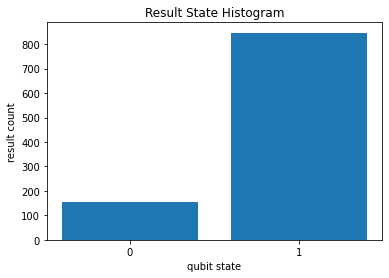

In [5]:
result = cirq.Simulator().run(circuit2, repetitions=1000)
print(result)
_ = cirq.vis.plot_state_histogram(result, plt.subplot())

# Task 4

The idea to transform the point-cloud data of this problem into graphs is quite simple. An almost immediate approach to this problem is to create a grid of a fixed dimension where we assign a pixel to each calorimeter cell, as shown below, and then proceed to perform a classification with classical convolutional networks. 

<img src="Screenshot_3.png">

Similarly, we will create a graph with each of the jets in the dataset. We will choose a fixed number of nodes for all the graphs, with the most representative particles of each jet. Each node will have two attributes: the energy of the particle and the id that characterizes it. In addition, all nodes will be connected to each other, and we will assign a weight to each of these edges corresponding to the relative distance separating the cells where the particles were detected in the calorimeter. That is, the weight of the connection between two nodes will be $d=\sqrt{(\Delta\phi)^2+(\Delta\eta)^{2}}$. Subsequently, we will use the DGL library to create our data dataset with which we will train a neural network composed of three convolutional layers.

In [6]:
import platform
import pandas as pd
from numpy import load
import torch
import sklearn
from sklearn.metrics import confusion_matrix
import itertools
import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import networkx as nx
from torch_geometric.utils.convert import to_networkx

Using backend: pytorch


In [7]:
Datrain=np.load('QG_jets.npz')
lst=Datrain.files
train=Datrain['X']
ltrain=Datrain['y']

In [8]:
train1=train[0:10000]
labelt=ltrain[0:10000]
train_label = torch.from_numpy(labelt)

In [9]:
n= 10000
ntrain= int(n * 0.8)
nval = int(n * 0.1)
ntest= int(n * 0.1)

In [10]:
class GraphDataset(dgl.data.DGLDataset):
    def __init__(self):
        super().__init__(name='graph_class') 
  
    def process(self):
        self.graphs = []
        self.labels = []
    
        #data_list=[]
        for k in range(n):
            b=20
            je=k

            t1=torch.tensor([])
            tf=torch.tensor([])
            tw=torch.tensor([])
            for i in range(b):
                for j in range(b):
                    if i!=j:
                        t2=torch.tensor([
                                        [i],
                                        [j]
                                        ])
                        t1=torch.cat((t1,t2),dim=1)
                  
                        d=np.sqrt((train1[je][i][1]-train1[je][j][1])**2+(train1[je][i][2]-train1[je][j][2])**2)
                        tw2=torch.tensor([[d]])
                        tw=torch.cat((tw,tw2),dim=0)
            
                tf2=torch.tensor([[train1[je][i][0],train1[je][i][3]]])
                tf=torch.cat((tf,tf2),dim=0)       
        
            t1=torch.unsqueeze(t1,dim=0)
            tf=torch.unsqueeze(tf,dim=0)
            tw=torch.unsqueeze(tw,dim=0)
        
            t1=torch.squeeze(t1)
            tf=torch.squeeze(tf)
            tw=torch.squeeze(tw)
        
            td1=t1[0].int().tolist()
            td2=t1[1].int().tolist()
            g3=dgl.graph((td1,td2))
        
            g3.ndata['value']=tf
            g3.ndata['label']=torch.LongTensor([train_label[k].int()]*b)
            g3.edata['weights']=tw
        #graph=Data(x=tf,edge_index=t1,edge_attr=tw)
       
            self.graphs.append(g3)
            self.labels.append(int(train_label[k]))
        self.labels = torch.LongTensor(self.labels)
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

graphdataset = GraphDataset()
g, label = graphdataset[500]
print(g)
print(label)

Graph(num_nodes=20, num_edges=380,
      ndata_schemes={'value': Scheme(shape=(2,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weights': Scheme(shape=(), dtype=torch.float64)})
tensor(0)


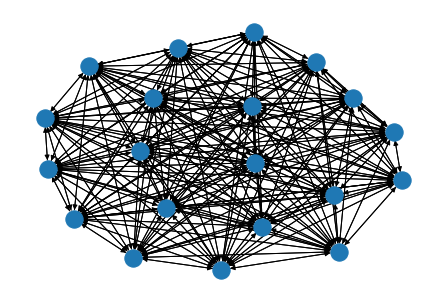

In [11]:
gx=dgl.to_networkx(g)
nx.draw(gx)

In [12]:
ts = SubsetRandomSampler(torch.arange(8000))
loadertrain = GraphDataLoader(graphdataset, sampler=ts, batch_size=5, drop_last=False)

vs = SubsetRandomSampler(torch.arange(8000, 9000))
loaderval = GraphDataLoader(graphdataset, sampler=vs, batch_size=5, drop_last=False)

tes = SubsetRandomSampler(torch.arange(9000, 10000))
loadertest = GraphDataLoader(graphdataset, sampler=tes, batch_size=5, drop_last=False)

batch = next(iter(loadertrain))
print(batch)

[Graph(num_nodes=100, num_edges=1900,
      ndata_schemes={'value': Scheme(shape=(2,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weights': Scheme(shape=(), dtype=torch.float64)}), tensor([0, 1, 1, 1, 1])]


In [13]:
batched_graph, labels = batch
graphs = dgl.unbatch(batched_graph)

In [14]:
class GraphModel(torch.nn.Module):
    def __init__(self):
        super(GraphModel, self).__init__()
        self.conv1 = GraphConv(2, 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, 2)

    def forward(self, g,feat):
        f = self.conv1(g, feat)
        f = torch.nn.functional.relu(f)
        f = self.conv2(g, f)
        f = torch.nn.functional.relu(f)
        f = self.conv3(g, f)
        g.ndata['f'] = f
        return dgl.mean_nodes(g, 'f')

graphmodel = GraphModel()

In [23]:
def train(loadertrain, loadertest, model, epochs):
    losses = []
    accuracy_test=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for e in range(epochs):
        train_loss_batch = []
    
        for batched_graph, labels in loadertrain:
            model.train()
            batched_graph, labels = batched_graph.to('cpu'), labels.to('cpu')
            logits = model(batched_graph, batched_graph.ndata['value'].float())
            pred = logits.argmax(1)
            loss = torch.nn.functional.cross_entropy(logits, labels)
            train_loss_batch.append(loss)
            with torch.no_grad():  
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(sum(train_loss_batch) / len(train_loss_batch))

        model.eval()
        
        if e % 2 == 0:
            print('Epoch {}, loss: {:.8f}'.format(e, loss))
        
    for batched_graph_test, labels_test in loadertest:
        batched_graph_test, labels_test = batched_graph_test.to('cpu'), labels_test.to('cpu')
        logits_test = model(batched_graph_test, batched_graph_test.ndata['value'].float())
        pred_test = logits_test.argmax(1)

    return losses

In [24]:
losses= train(loadertrain, loadertest, graphmodel, 20)

C:\Users\leon-\anaconda3\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 0, loss: 0.48118550
Epoch 2, loss: 0.47928056
Epoch 4, loss: 0.77752823
Epoch 6, loss: 0.55695862
Epoch 8, loss: 0.72158134
Epoch 10, loss: 0.68107456
Epoch 12, loss: 0.48858181
Epoch 14, loss: 0.52441847
Epoch 16, loss: 0.53954947
Epoch 18, loss: 0.33938053


In [27]:
pred_labels = []
real_labels=[]
m=0
for batched_graph_test, labels_test in loadertest:
    m=m+1
    batched_graph_test = batched_graph_test.to('cpu')
    labels_test = labels_test.to('cpu')
    logits_test = graphmodel(batched_graph_test, batched_graph_test.ndata['value'].float())
    pred_test = logits_test.argmax(1)
    pred_labels = pred_labels + [*pred_test.cpu().numpy()]
    real_labels=real_labels+[*labels_test.numpy()]
#print(m)

In [28]:
#%pprint
real_labels

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 

In [29]:
print(type(pred_labels))
print(pred_labels)

<class 'list'>
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 

In [30]:
lista=pred_labels
len(lista)

1000

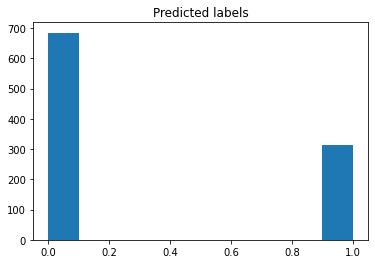

In [31]:
plt.hist(lista)
plt.title("Predicted labels")
plt.show()

Confusion matrix, without normalization
[[457  68]
 [228 247]]


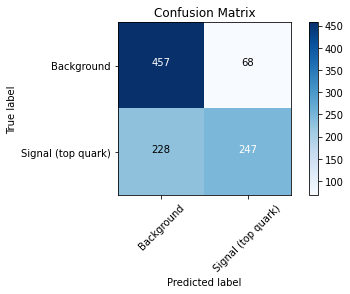

In [32]:
cm=confusion_matrix(y_true=real_labels,y_pred=pred_labels)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_labels=['Background', 'Signal (top quark)']    
plot_confusion_matrix(cm=cm,classes=cm_labels,title='Confusion Matrix')

# Task V

I firmly believe the future of scientific research lies in artificial intelligence technologies. Every year, I see more papers using some machine learning technique to draw conclusions from huge data sets, and this is due, among other things, to the increasing capacity and accessibility of computers. The role of quantum computing in this regard is to speed up this trend, or that is what it is intended to be demonstrated.

I made my decision to pursue a career in quantum computing when I realized the need to find new ways of describing the physical world, with the goal of creating new technological solutions to the social and environmental problems of this century, but also to better understand how our universe is composed at more fundamental scales. High Energy Physics is an area where new methodologies will be most needed to handle the enormous amounts of data obtained from experiments such as the LHC.

For my undergraduate thesis, I have worked on something very similar to Task IV: I also classified gluons and quarks, but representing each of the jets through an image, and then using Quantum Convolutional Neural Networks (a hybrid one) to distinguish them. However, when performing Task IV, I realized that a more efficient way to do it is through GNN. As this work has been the first approach I have had with GNNs, and taking into account all the material I consulted in the last weeks to do this project, I am very excited to be able to use other types of graph networks and libraries in similar tasks. In particular, I would like to explore the use of the Pytorch Geometric library for this training. I am very curious to implement PG's Advanced Mini-Batch procedure to get better results than with DGL batching, and moreover, to look for counterpart or hybrid ways to use a quantum algorithm in this procedure. 

From previous projects, I have experience working with Qiskit. Specifically, in addition to my thesis, I made a manual of Quantum Support Vector Machines for didactic use in my faculty, where we realized that, at least in this procedure, a performance equal to that of classical algorithms was only achieved when the dataset could be linearly separated using very complicated kernel functions. 

I am eager to explore approaches to QML with graphical models, hoping that it will be in deep learning where the first hints of the quantum advantage will be found.